# Welcome to the JupyterLab Version of the NanoObjectDetection Package

## First Load the standard libraries

In [1]:
# Standard Libraries
from __future__ import division, unicode_literals, print_function # For compatibility with Python 2 and 3
from importlib import reload # only used for debugging --> reload(package_name)

# for easy debugging
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import qgrid

import sys
import os
sys.path.insert(0, os.path.abspath(r'C:\Users\foersterronny\Documents\GitHub'))

# Own Library
import NanoObjectDetection as nd

debugger = False
NewEvaluation = False

## Execute this for new data

In [2]:
# reload(nd.Start)
if NewEvaluation == True: nd.Start.NewEvaluation()

## path of parameter file

In [4]:
#%% 
# this can be replaced by any json file
ParameterJsonFile = \
r'\\mars\usr\FA2_Faseroptik\FAG24_Faseropt_Systeme\Foerster\Data\NanoObjectDetection\light_cage\TrackingSetupZeiss\gold_80nm\633nm\Jisoo\data-1st\parameter.json'

## read in the raw data into numpy

start reading in raw images. (That may take a while...)
\\mars\usr\FA2_Faseroptik\FAG24_Faseropt_Systeme\Foerster\Data\NanoObjectDetection\light_cage\TrackingSetupZeiss\gold_80nm\633nm\Jisoo\80nm-150us-1st.tif
finishied reading in raw images =)
Perform a sanity check for the raw data...


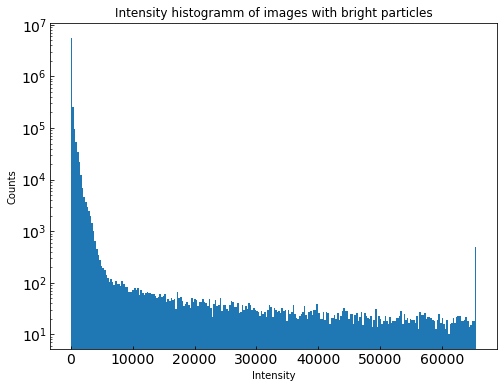

An intensity histogramm should be plotted. The highest intensity bin should not be a peak. If you see such a peak, you probably have saturation. Do you have saturation [y/n]?n


interactive(children=(IntSlider(value=1, description='Frame', max=4999, min=1), IntRangeSlider(value=(0, 259),…

In [5]:
rawframes_np = nd.handle_data.ReadData2Numpy(ParameterJsonFile)

reload(nd.JupyterLab)
nd.JupyterLab.Show3dImage(rawframes_np)

## ROI - Set Parameters

In [6]:
reload(nd.JupyterLab)
nd.JupyterLab.ChooseROIParameters(rawframes_np, ParameterJsonFile)

interactive(children=(IntSlider(value=1, description='Apply ROI (0 - no, 1 - yes)', max=1), Output()), _dom_cl…

## ROI - Apply

In [17]:
rawframes_super = nd.handle_data.UseROI(rawframes_np, ParameterJsonFile)

#ignore supersamping for the moment since it is not really used, yet

ROI IS applied
Size rawdata (frames, height, length): (5000, 260, 320)
Size ROI (frames, height, length): (100, 259, 319)


## Standard Image Preprocessing - Set Parameters

In [18]:
reload(nd.PreProcessing)
reload(nd.visualize)
reload(nd.JupyterLab)
nd.JupyterLab.ChoosePreProcessingParameters(rawframes_super, ParameterJsonFile)

interactive(children=(IntSlider(value=0, description='Correct Laser fluctuations (0 - no, 1 - yes)', max=1), O…

interactive(children=(IntSlider(value=1, description='Correct camera offset (0 - no, 1 - yes)', max=1), Output…

interactive(children=(IntSlider(value=1, description='Correct static background (0 - no, 1 - yes)', max=1), In…

RollingPercentilFilter not inserted yet
Clipping negative values not inserted yet. Clipping is bad
Rotating the image is not inserted yet. Rotate your camera if that is a problem.


## Standard Image Preprocessing - Apply

Laser fluctuations: not removed
Constant camera background: start removing
Camera offset is:  0.0
Constant camera background: removed
Static background: start removing
Static background: removed
Rolling percentil filter: not applied
Negative values: kept
Convolve rawframe by PSF to enhance SNR: start removing
Gauss Kernel in px: 1.8929041280570924
Do it parallel
Parallel finished
Convolve rawframe by PSF to enhance SNR: removed
Image Rotation: not applied


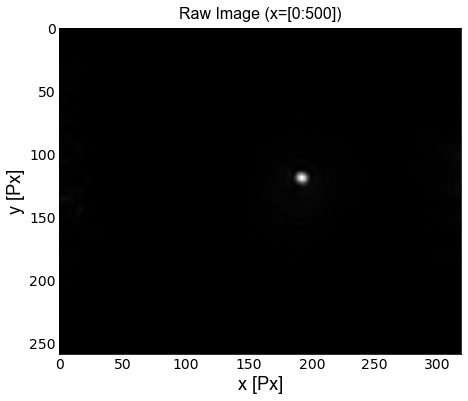

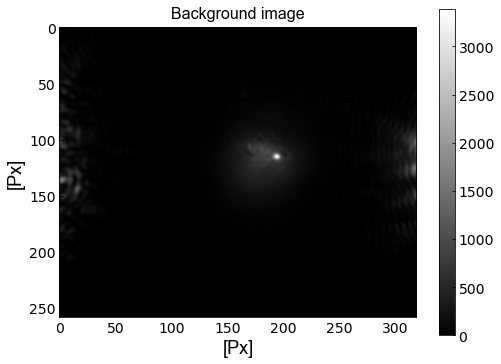

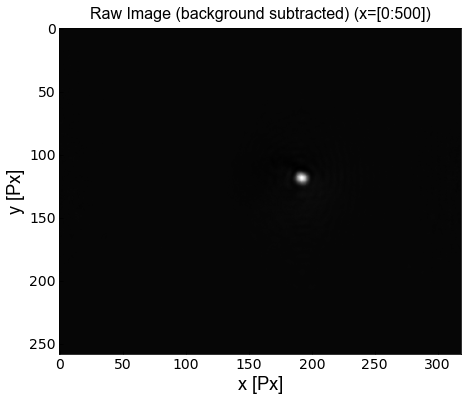

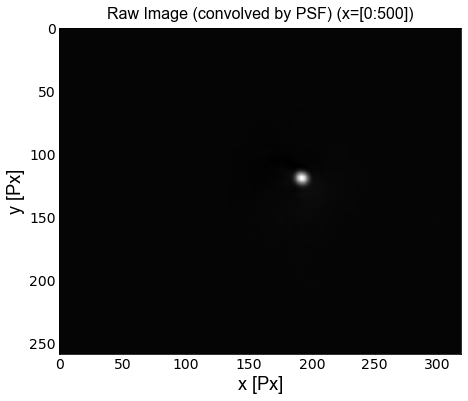

interactive(children=(IntRangeSlider(value=(0, 258), description='ROI - y', max=258, step=5), IntRangeSlider(v…

interactive(children=(IntSlider(value=1, description='Frame', max=99, min=1), IntRangeSlider(value=(0, 258), d…

In [19]:
#reload(nd.PreProcessing)
reload(nd.JupyterLab)
rawframes_pre, static_background = nd.PreProcessing.Main(rawframes_super, ParameterJsonFile)
nd.JupyterLab.Show2dImage(static_background, title = "Background")
nd.JupyterLab.Show3dImage(rawframes_pre, title = "Raw Image")

## help with the parameters for finding objects 

In [20]:
settings = nd.handle_data.ReadJson(ParameterJsonFile)

reload(nd.ParameterEstimation)
reload(nd.JupyterLab)
reload(nd.get_trajectorie)
reload(nd.AdjustSettings)
nd.JupyterLab.ChooseFindObjParameters(rawframes_pre, ParameterJsonFile)

#nd.AdjustSettings.AdjustSettings_Main(rawframes_pre, ParameterJsonFile)

interactive(children=(Dropdown(description='Help separation distance', index=1, options=('0', 'auto'), value='…

interactive(children=(Dropdown(description='Help bead diameter', index=1, options=('0', 'manual', 'auto'), val…

interactive(children=(Dropdown(description='Help bead minmass', index=1, options=('0', 'manual', 'auto'), valu…

## find the objects

In [9]:
reload(nd.get_trajectorie)
obj_all = nd.get_trajectorie.FindSpots(rawframes_pre, ParameterJsonFile)

qgrid.show_grid(obj_all, show_toolbar=True)

Frame 1499: 11 features
Set all NaN in estimation precision to 0


QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

## identify static objects - find trajectories of very slow diffusing (maybe stationary) objects

In [10]:
reload(nd.get_trajectorie)

t1_orig_slow_diff = nd.get_trajectorie.link_df(obj_all, ParameterJsonFile, SearchFixedParticles = True)
# qgrid.show_grid(t1_orig_slow_diff, show_toolbar=True)

# delete trajectories which are not long enough. stationary objects have long trajcetories and survive the test   
t2_stationary = nd.get_trajectorie.filter_stubs(t1_orig_slow_diff, ParameterJsonFile, FixedParticles = True, BeforeDriftCorrection = True)

# qgrid.show_grid(t2_stationary, show_toolbar=True)

Frame 1499: 11 trajectories present.
New method here.
Minimum trajectorie length:  15.0
Number of stationary objects (might be detected multiple times after being dark): 20


## cut trajectories when a moving particles comes to close to a stationary object

In [11]:
obj_moving = nd.get_trajectorie.RemoveSpotsInNoGoAreas(obj_all, t2_stationary, ParameterJsonFile)

#qgrid.show_grid(obj_moving, show_toolbar=True)

min_distance to stationary object:  20
Remove Spots In No Go Areas: [##################################################] 100% DONE


## remove overexposed objects

In [12]:
obj_moving = nd.get_trajectorie.RemoveOverexposedObjects(ParameterJsonFile, obj_moving, rawframes_pre)
# qgrid.show_grid(obj_moving, show_toolbar=True)

Deleted overexposed particles!


## form trajectories of valid particle positions

In [13]:
t1_orig = nd.get_trajectorie.link_df(obj_moving, ParameterJsonFile, SearchFixedParticles = False) 
# qgrid.show_grid(t1_orig, show_toolbar=True)

Frame 1499: 9 trajectories present.


## remove to short trajectories

In [14]:
t2_long = nd.get_trajectorie.filter_stubs(t1_orig, ParameterJsonFile, FixedParticles = False, BeforeDriftCorrection = True)
# qgrid.show_grid(t2_long, show_toolbar=True)

Minimum trajectorie length:  15.0
Too short trajectories removed!
Before: 1464, After: 252, Removed: 1212 (82%)


## identify and close gaps in the trajectory & calculate intensity fluctuations as a sign of wrong assignment

In [15]:
t3_gapless = nd.get_trajectorie.close_gaps(t2_long)
t3_gapless = nd.get_trajectorie.calc_intensity_fluctuations(t3_gapless, ParameterJsonFile)
# qgrid.show_grid(t3_gapless, show_toolbar=True)

Close gaps in trajectories: [##################################################] 100% DONE


## split trajectories if necessary (e.g. to large intensity jumps)

In [16]:
t4_cutted, t4_cutted_no_gaps = nd.get_trajectorie.split_traj(t2_long, t3_gapless, ParameterJsonFile)
qgrid.show_grid(t4_cutted, show_toolbar=True)

Split trajectories at high intensity jumps: [##################################################] 100% DONE
Trajectories with risk of wrong assignments (i.e. before splitting): 252
Trajectories with reduced risk of wrong assignments (i.e. after splitting): 255
Number of performed trajectory splits: 128
Number of concerned trajectories: 29 (11%)
Number of trajectories that became too short and were filtered out: 10
Close gaps in trajectories: [##################################################] 100% DONE


QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

## drift correction

In [17]:
reload(nd.Drift)

t5_no_drift = nd.Drift.DriftCorrection(t4_cutted, ParameterJsonFile, PlotGlobalDrift = False)
# qgrid.show_grid(t5_no_drift, show_toolbar=True)

The drift correction is done by averaging over:  10  frames
Mode: global drift correction
drift correction --> finished


## only long trajectories are used in the msd plort in order to get a good fit

Minimum trajectorie length:  30.0
Too short trajectories removed!
Before: 255, After: 143, Removed: 112 (43%)
particleid:  9.0
particleid:  7.0
Error in Traj. This can be plotted, if code here is switched on.


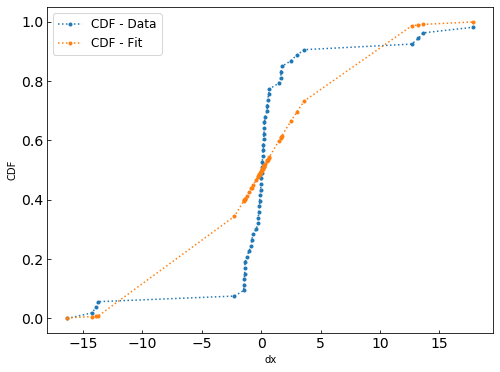

Drop particleID (because of unbrownian trajectory):  7.0
Significance:  0.00011101211104216311
particleid:  29.0
particleid:  33.0
particleid:  37.0
particleid:  38.0
particleid:  1434.0
Error in Traj. This can be plotted, if code here is switched on.


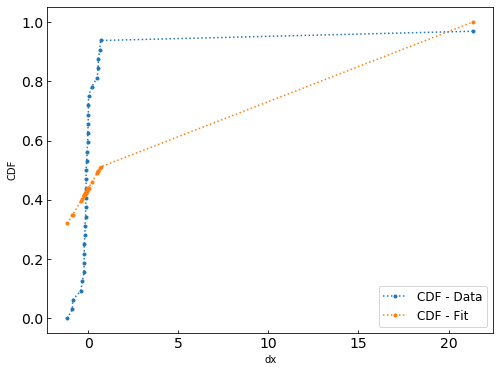

Drop particleID (because of unbrownian trajectory):  1434.0
Significance:  8.637104145461449e-07
particleid:  52.0
Error in Traj. This can be plotted, if code here is switched on.


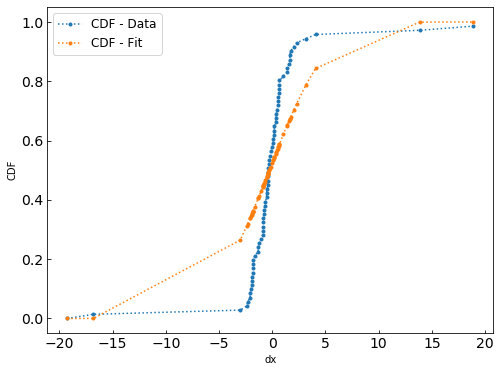

Drop particleID (because of unbrownian trajectory):  52.0
Significance:  5.3405141848641314e-05
particleid:  1443.0
particleid:  101.0
particleid:  118.0
particleid:  127.0
particleid:  49.0
Error in Traj. This can be plotted, if code here is switched on.


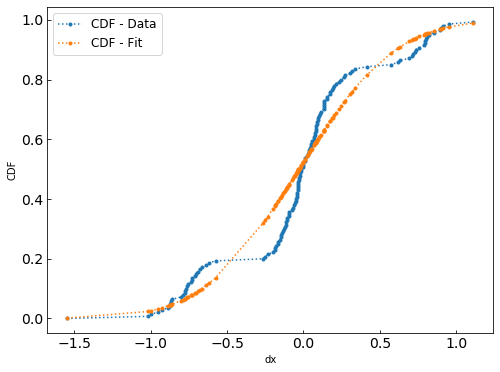

Drop particleID (because of unbrownian trajectory):  49.0
Significance:  0.00461992840707958
particleid:  147.0
particleid:  155.0
particleid:  157.0
particleid:  169.0
particleid:  182.0
Error in Traj. This can be plotted, if code here is switched on.


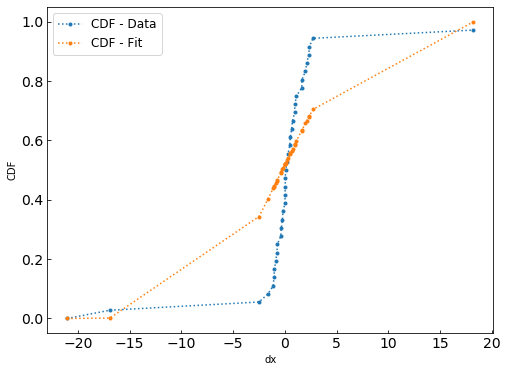

Drop particleID (because of unbrownian trajectory):  182.0
Significance:  0.0007057569545569562
particleid:  185.0
particleid:  1447.0
particleid:  194.0
particleid:  199.0
Error in Traj. This can be plotted, if code here is switched on.


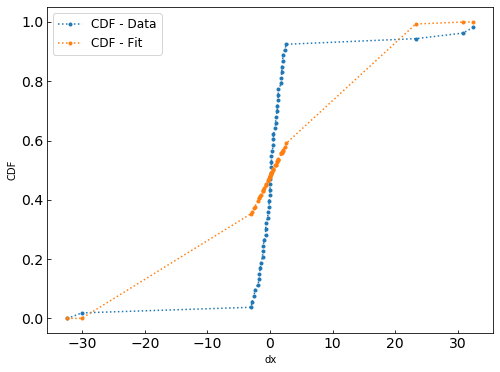

Drop particleID (because of unbrownian trajectory):  199.0
Significance:  1.8504840855079825e-06
particleid:  202.0
particleid:  226.0
Error in Traj. This can be plotted, if code here is switched on.


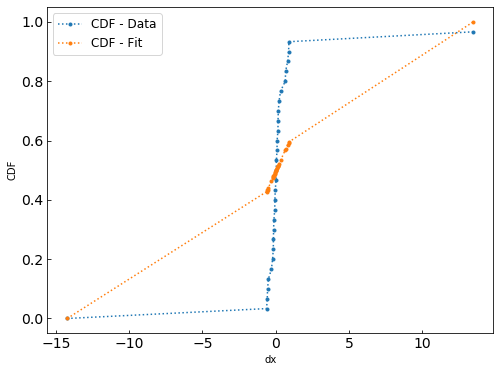

Drop particleID (because of unbrownian trajectory):  226.0
Significance:  5.846914727641032e-06
particleid:  238.0
Error in Traj. This can be plotted, if code here is switched on.


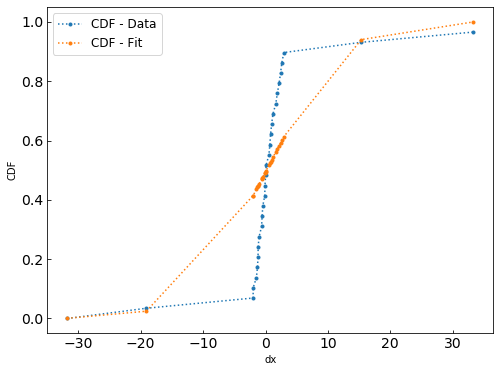

Drop particleID (because of unbrownian trajectory):  238.0
Significance:  0.00023161804834568466
particleid:  259.0
Error in Traj. This can be plotted, if code here is switched on.


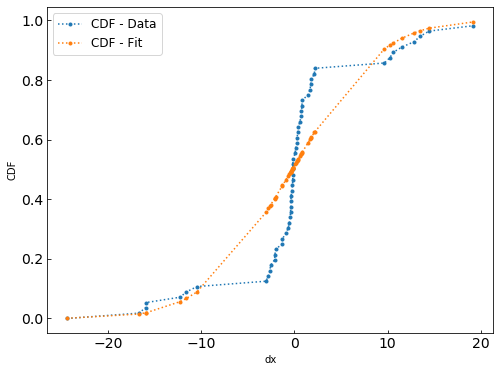

Drop particleID (because of unbrownian trajectory):  259.0
Significance:  0.004353327454560351
particleid:  1451.0
particleid:  265.0
Error in Traj. This can be plotted, if code here is switched on.


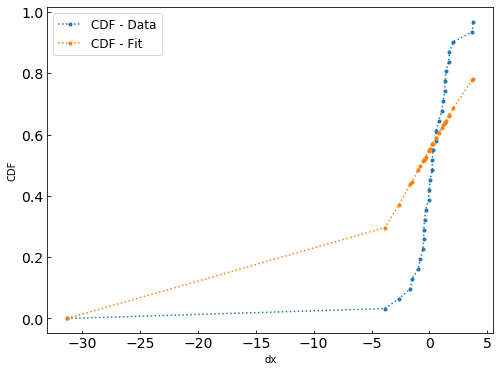

Drop particleID (because of unbrownian trajectory):  265.0
Significance:  0.0004464354654911842
particleid:  278.0
particleid:  280.0
particleid:  289.0
Error in Traj. This can be plotted, if code here is switched on.


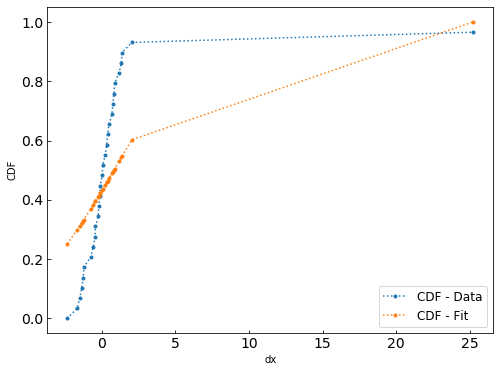

Drop particleID (because of unbrownian trajectory):  289.0
Significance:  0.0002905385650372418
particleid:  297.0
particleid:  296.0
Error in Traj. This can be plotted, if code here is switched on.


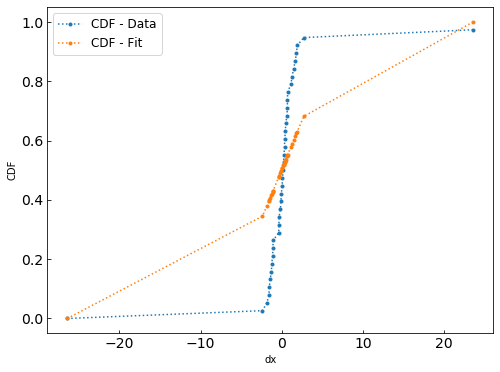

Drop particleID (because of unbrownian trajectory):  296.0
Significance:  0.00031253972249317176
particleid:  301.0
Error in Traj. This can be plotted, if code here is switched on.


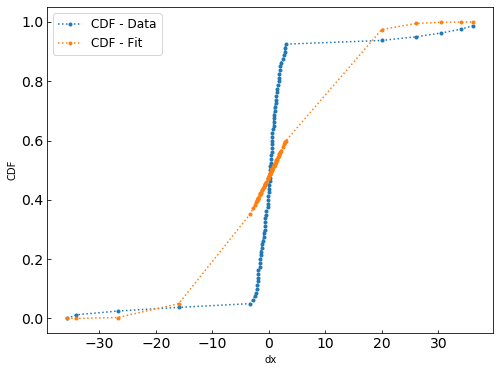

Drop particleID (because of unbrownian trajectory):  301.0
Significance:  1.6635875832300405e-08
particleid:  313.0
Error in Traj. This can be plotted, if code here is switched on.


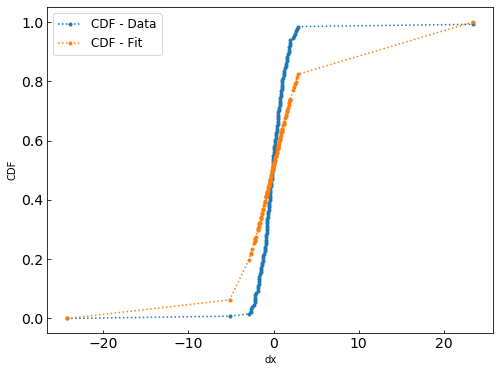

Drop particleID (because of unbrownian trajectory):  313.0
Significance:  1.605488817263839e-05
particleid:  329.0
particleid:  335.0
particleid:  344.0
Error in Traj. This can be plotted, if code here is switched on.


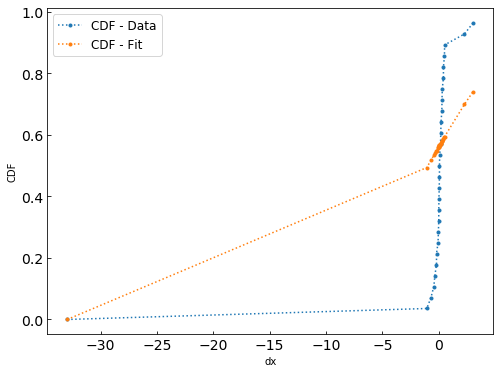

Drop particleID (because of unbrownian trajectory):  344.0
Significance:  1.8981498528236359e-06
particleid:  346.0
Error in Traj. This can be plotted, if code here is switched on.


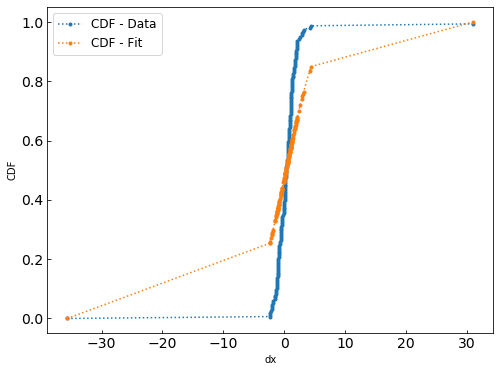

Drop particleID (because of unbrownian trajectory):  346.0
Significance:  7.10384419440921e-10
particleid:  350.0
particleid:  354.0
particleid:  355.0
particleid:  368.0
particleid:  395.0
particleid:  398.0
particleid:  400.0
particleid:  409.0
particleid:  415.0
particleid:  445.0
particleid:  475.0
particleid:  479.0
particleid:  490.0
particleid:  493.0
Error in Traj. This can be plotted, if code here is switched on.


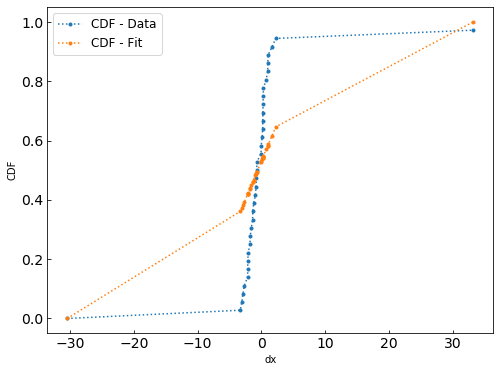

Drop particleID (because of unbrownian trajectory):  493.0
Significance:  0.0005381962578903349
particleid:  509.0
particleid:  512.0
Error in Traj. This can be plotted, if code here is switched on.


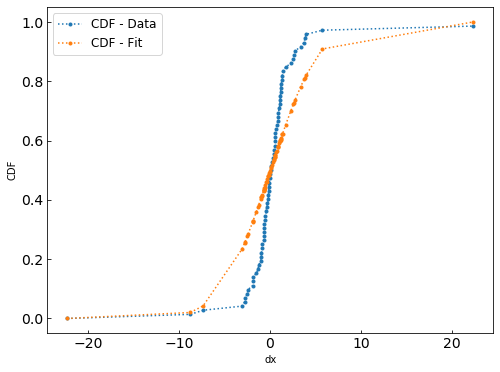

Drop particleID (because of unbrownian trajectory):  512.0
Significance:  0.0013134606692575134
particleid:  518.0
particleid:  521.0
particleid:  525.0
particleid:  531.0
Error in Traj. This can be plotted, if code here is switched on.


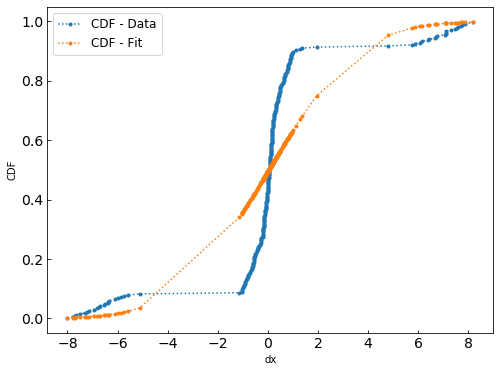

Drop particleID (because of unbrownian trajectory):  531.0
Significance:  8.102355616369327e-19
particleid:  545.0
Error in Traj. This can be plotted, if code here is switched on.


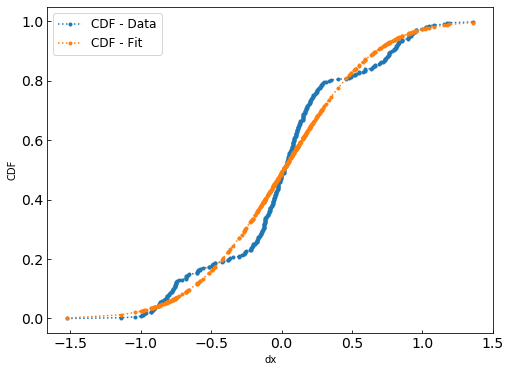

Drop particleID (because of unbrownian trajectory):  545.0
Significance:  0.0007490517354394068
particleid:  549.0
particleid:  550.0
particleid:  551.0
Error in Traj. This can be plotted, if code here is switched on.


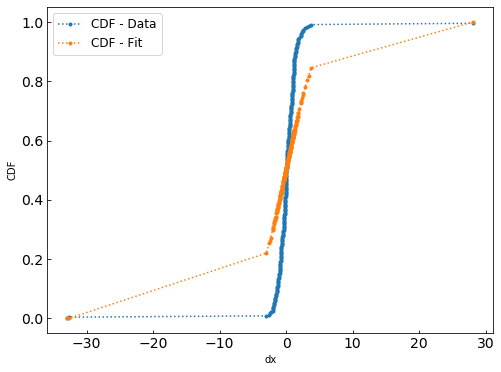

Drop particleID (because of unbrownian trajectory):  551.0
Significance:  1.8949851453753023e-15
particleid:  588.0
particleid:  590.0
particleid:  617.0
particleid:  1469.0
Error in Traj. This can be plotted, if code here is switched on.


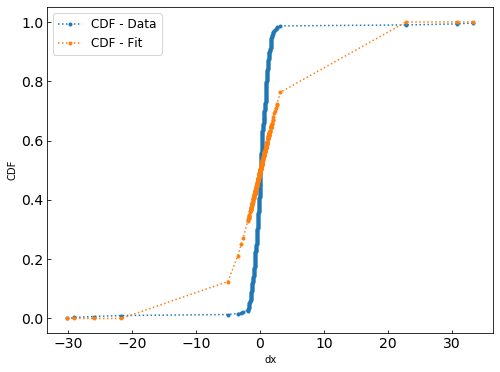

Drop particleID (because of unbrownian trajectory):  1469.0
Significance:  8.484182651041357e-25
particleid:  635.0
particleid:  652.0
particleid:  661.0
particleid:  679.0
particleid:  691.0
Error in Traj. This can be plotted, if code here is switched on.


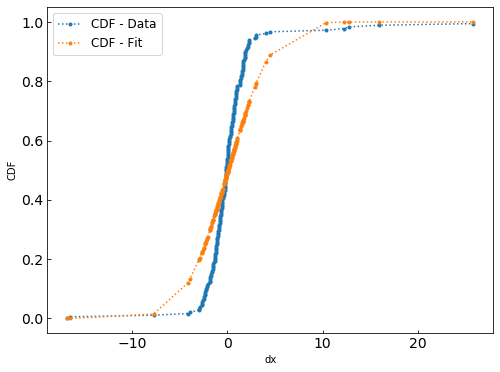

Drop particleID (because of unbrownian trajectory):  691.0
Significance:  1.404275324039001e-07
particleid:  694.0
particleid:  696.0
particleid:  717.0
particleid:  721.0
particleid:  727.0
particleid:  732.0
particleid:  733.0
particleid:  757.0
Error in Traj. This can be plotted, if code here is switched on.


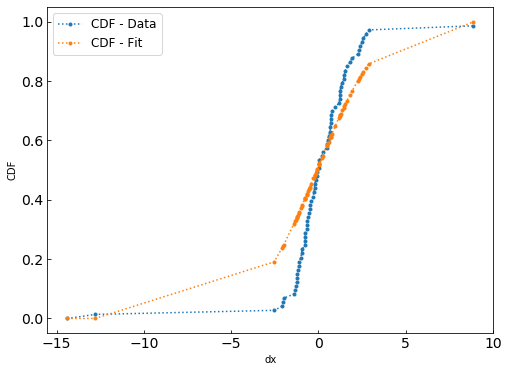

Drop particleID (because of unbrownian trajectory):  757.0
Significance:  0.00031771438317665986
particleid:  769.0
particleid:  1508.0
particleid:  788.0
particleid:  793.0
particleid:  809.0
particleid:  832.0
particleid:  835.0
particleid:  836.0
particleid:  843.0
particleid:  857.0
Error in Traj. This can be plotted, if code here is switched on.


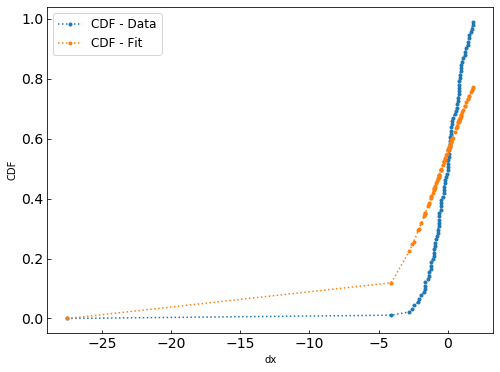

Drop particleID (because of unbrownian trajectory):  857.0
Significance:  1.366030987947941e-05
particleid:  864.0
particleid:  865.0
particleid:  870.0
particleid:  884.0
Error in Traj. This can be plotted, if code here is switched on.


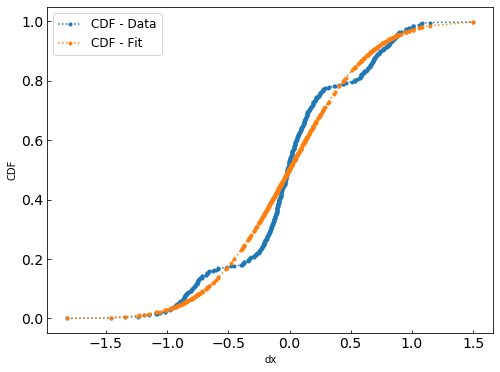

Drop particleID (because of unbrownian trajectory):  884.0
Significance:  9.282213961345422e-05
particleid:  899.0
particleid:  905.0
particleid:  914.0
Error in Traj. This can be plotted, if code here is switched on.


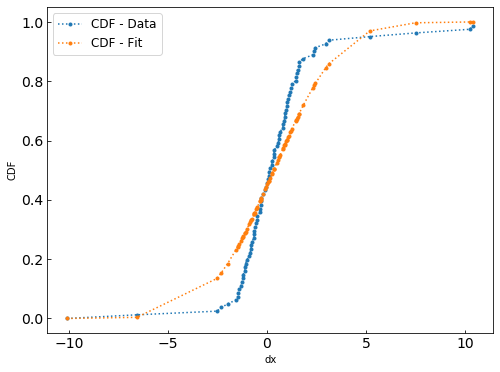

Drop particleID (because of unbrownian trajectory):  914.0
Significance:  0.0064975010560635715
particleid:  917.0
particleid:  923.0
Error in Traj. This can be plotted, if code here is switched on.


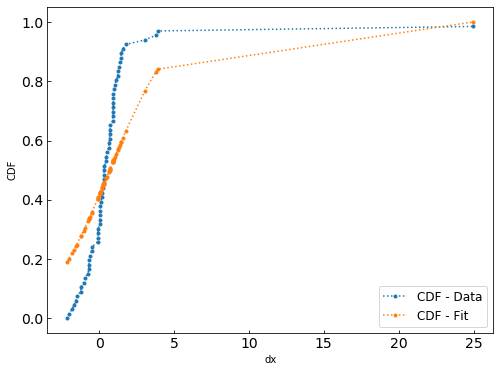

Drop particleID (because of unbrownian trajectory):  923.0
Significance:  3.1890814986576352e-06
particleid:  928.0
particleid:  929.0
Error in Traj. This can be plotted, if code here is switched on.


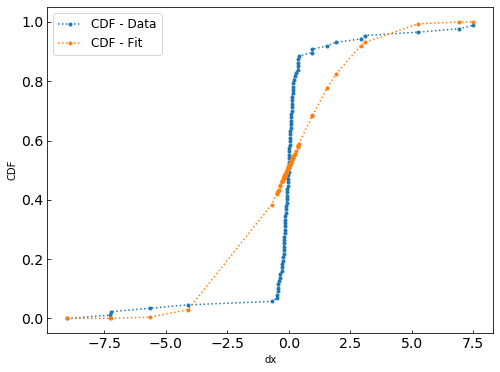

Drop particleID (because of unbrownian trajectory):  929.0
Significance:  5.7113359260478823e-11
particleid:  954.0
particleid:  1518.0
Error in Traj. This can be plotted, if code here is switched on.


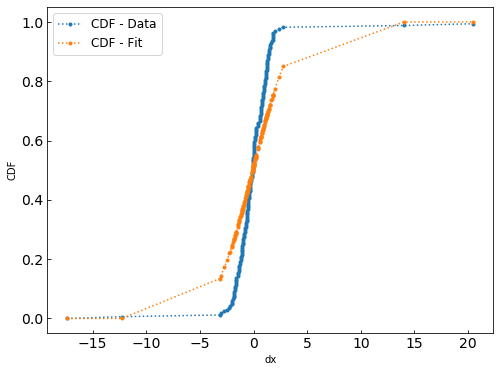

Drop particleID (because of unbrownian trajectory):  1518.0
Significance:  2.4171560527561697e-07
particleid:  968.0
particleid:  992.0
particleid:  994.0
particleid:  1004.0
particleid:  1005.0
particleid:  1018.0
Error in Traj. This can be plotted, if code here is switched on.


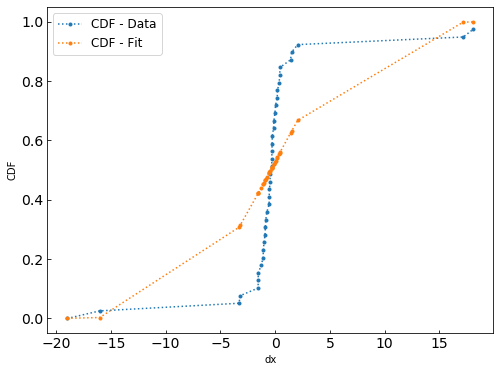

Drop particleID (because of unbrownian trajectory):  1018.0
Significance:  0.00039327632242260285
particleid:  1037.0
particleid:  1040.0
particleid:  1044.0
particleid:  1045.0
particleid:  1053.0
particleid:  1055.0
particleid:  1521.0
Error in Traj. This can be plotted, if code here is switched on.


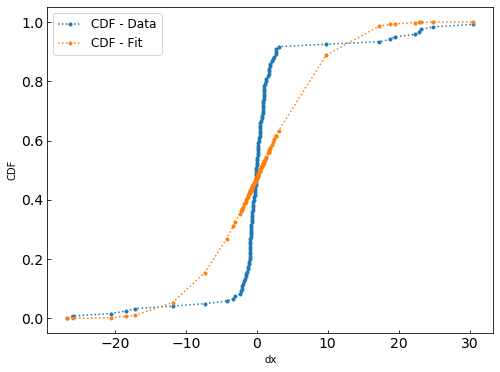

Drop particleID (because of unbrownian trajectory):  1521.0
Significance:  2.9348438363361446e-10
particleid:  1062.0
particleid:  1065.0
particleid:  1070.0
particleid:  1086.0
particleid:  1103.0
particleid:  1134.0
particleid:  1174.0
particleid:  1182.0
particleid:  1185.0
particleid:  1190.0
particleid:  1196.0
Error in Traj. This can be plotted, if code here is switched on.


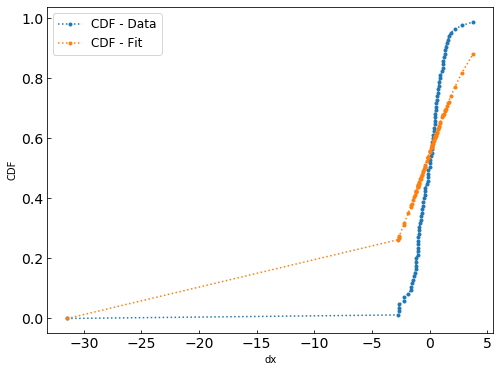

Drop particleID (because of unbrownian trajectory):  1196.0
Significance:  3.05766006467317e-06
particleid:  1199.0
Error in Traj. This can be plotted, if code here is switched on.


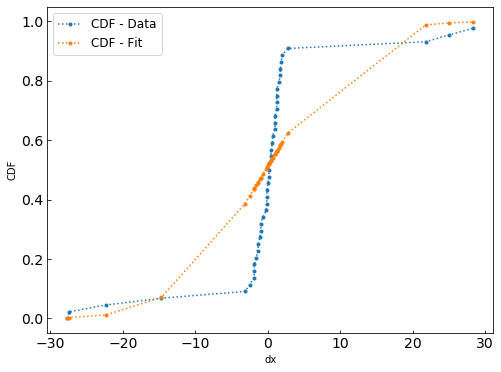

Drop particleID (because of unbrownian trajectory):  1199.0
Significance:  0.00027078795282838264
particleid:  1222.0
Error in Traj. This can be plotted, if code here is switched on.


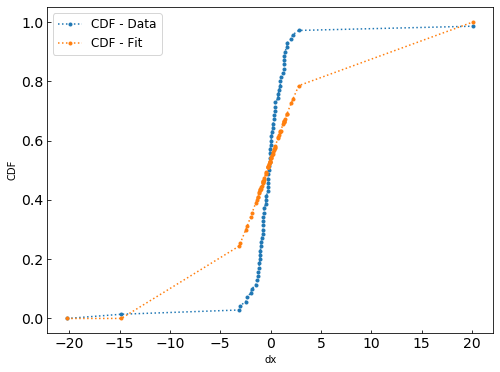

Drop particleID (because of unbrownian trajectory):  1222.0
Significance:  2.379144745788841e-05
particleid:  1230.0
particleid:  1267.0
particleid:  1306.0
particleid:  1329.0
particleid:  1327.0
particleid:  1333.0
Error in Traj. This can be plotted, if code here is switched on.


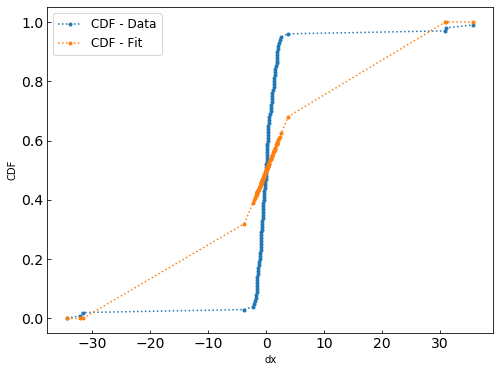

Drop particleID (because of unbrownian trajectory):  1333.0
Significance:  8.932179126802362e-12
particleid:  1343.0
particleid:  1355.0
Error in Traj. This can be plotted, if code here is switched on.


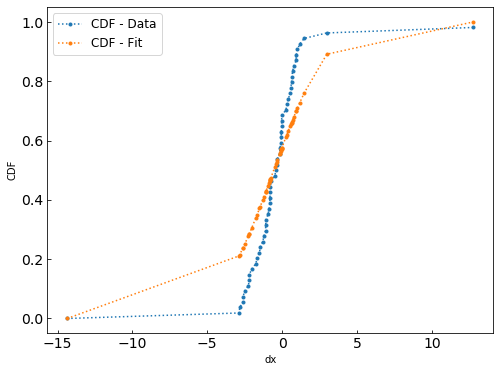

Drop particleID (because of unbrownian trajectory):  1355.0
Significance:  0.006565543523556342
particleid:  1372.0
Error in Traj. This can be plotted, if code here is switched on.


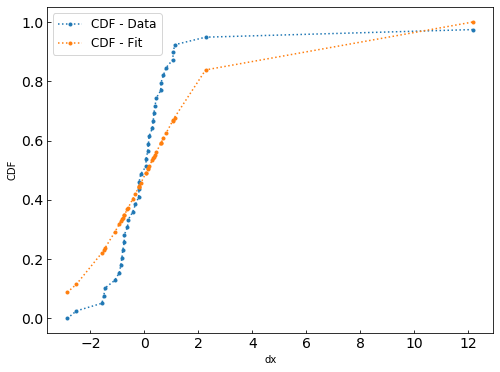

Drop particleID (because of unbrownian trajectory):  1372.0
Significance:  0.005600273397379405
particleid:  1373.0
particleid:  1383.0
particleid:  1394.0
particleid:  1536.0
particleid:  1416.0
Error in Traj. This can be plotted, if code here is switched on.


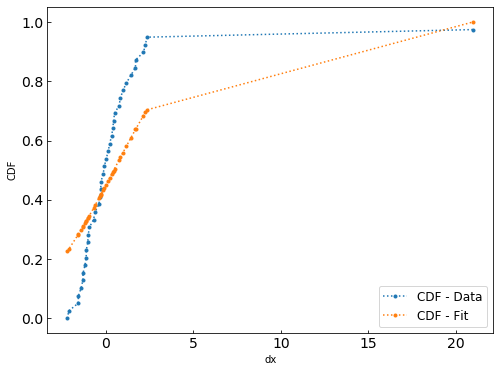

Drop particleID (because of unbrownian trajectory):  1416.0
Significance:  0.005659004099629387


QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [18]:
reload(nd.get_trajectorie)
reload(nd.CalcDiameter)
t6_final = nd.get_trajectorie.filter_stubs(t5_no_drift, ParameterJsonFile, FixedParticles = False, BeforeDriftCorrection = False)

qgrid.show_grid(t6_final, show_toolbar=True)

## calculate the msd and process to diffusion and diameter


 Particle number:  9
Starting Diameter: 48.7nm; hindrance factor: 1.020; Corrected Diameter: 47.78nm

 Particle number:  29
Starting Diameter: 58.8nm; hindrance factor: 1.023; Corrected Diameter: 57.54nm

 Particle number:  33
Starting Diameter: 28.7nm; hindrance factor: 1.013; Corrected Diameter: 28.40nm

 Particle number:  37
Starting Diameter: 142.3nm; hindrance factor: 1.047; Corrected Diameter: 136.04nm

 Particle number:  38
Starting Diameter: 61.5nm; hindrance factor: 1.024; Corrected Diameter: 60.10nm

 Particle number:  1443
Starting Diameter: 98.6nm; hindrance factor: 1.035; Corrected Diameter: 95.39nm

 Particle number:  101
Starting Diameter: 47.9nm; hindrance factor: 1.019; Corrected Diameter: 47.01nm

 Particle number:  118
Starting Diameter: 27.6nm; hindrance factor: 1.012; Corrected Diameter: 27.32nm

 Particle number:  127
Starting Diameter: 105.6nm; hindrance factor: 1.037; Corrected Diameter: 101.91nm

 Particle number:  147
Starting Diameter: 25.9nm; hindrance fact

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

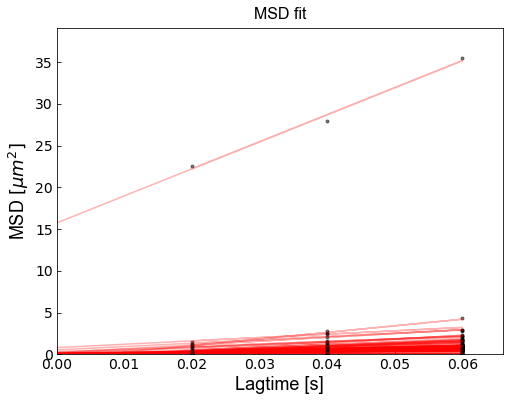

In [19]:
reload(nd.CalcDiameter)
sizes_df_lin, sizes_df_lin_rolling , any_successful_check = nd.CalcDiameter.Main(t6_final, ParameterJsonFile, obj_all, MSD_fit_Show = True)
qgrid.show_grid(sizes_df_lin, show_toolbar=True)

In [24]:
np.mean(sizes_df_lin[sizes_df_lin.diameter < 30])

diameter        NaN
diffusion       NaN
diffusion std   NaN
ep              NaN
redep           NaN
signal          NaN
mass            NaN
rawmass         NaN
max step        NaN
first frame     NaN
traj length     NaN
valid frames    NaN
size            NaN
ecc             NaN
stat_sign       NaN
true_particle   NaN
dtype: float64

## visualize results

dpi = 300
Figure saved at: \\mars\usr\FA2_Faseroptik\FAG24_Faseropt_Systeme\Foerster\Data\NanoObjectDetection\5er_revolver_1214b2\TrackingSetupOlympus\Gold\Laser_532nm\Torsten\exp_10nm_PED_11_06_2020\50fps_19700\analysis\200612\


 mean diameter:  60.8
68CI Intervall:  [33.2 92.9] 


dpi = 300
Figure saved at: \\mars\usr\FA2_Faseroptik\FAG24_Faseropt_Systeme\Foerster\Data\NanoObjectDetection\5er_revolver_1214b2\TrackingSetupOlympus\Gold\Laser_532nm\Torsten\exp_10nm_PED_11_06_2020\50fps_19700\analysis\200612\


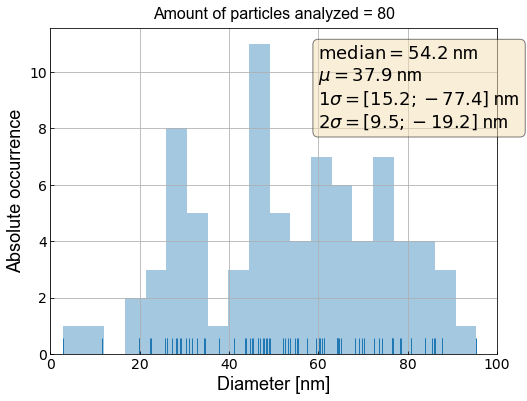

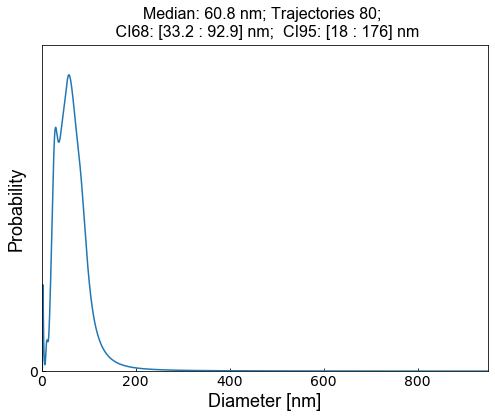

In [21]:
reload(nd.visualize)
nd.visualize.PlotDiameters(ParameterJsonFile, sizes_df_lin[sizes_df_lin.diameter < 100], any_successful_check)

In [ ]:
fig = plt.figure()
import matplotlib.colors as colors


In [ ]:
from ipywidgets import IntSlider, IntRangeSlider, FloatLogSlider
import matplotlib.colors as colors

[max_f, max_y, max_x] = np.asarray(rawframes_ROI.shape) - 1

def ShowRawImage(frame, y_range, x_range, my_gamma):  
    
    fig, axes = plt.subplots(3,1, sharex = True,figsize=(15,10))
    
    y_min = y_range[0]
    y_max = y_range[1]+1
    x_min = x_range[0]
    x_max = x_range[1]+1
     
    axes[0].imshow(rawframes_ROI[frame,y_min:y_max, x_min:x_max], cmap = 'gray', norm=colors.PowerNorm(gamma=my_gamma))
    axes[0].set_title("Raw Image")
    axes[0].set_ylabel("y [Px]")
    
    axes[1].imshow(static_background[y_min:y_max, x_min:x_max], cmap = 'gray', norm=colors.PowerNorm(gamma=my_gamma))
    axes[1].set_title("Background")
    axes[1].set_ylabel("y [Px]")
    
    axes[2].imshow(rawframes_pre[frame, y_min:y_max, x_min:x_max], cmap = 'gray', norm=colors.PowerNorm(gamma=my_gamma))
    axes[2].set_title("Corrected Background")
    axes[2].set_xlabel("x [Px]")
    axes[2].set_ylabel("y [Px]")    
    
    fig.tight_layout()
    
    
frame_slider = IntSlider(min = 1, max = max_f, description = "Frame")    
y_range_slider = IntRangeSlider(value=[0, max_y], min=0, max=max_y, description = "ROI - y")
x_range_slider = IntRangeSlider(value=[0, max_x], min=0, max=max_x, description = "ROI - x")
gamma_slider = FloatSlider(min = 0.1, max = 2, step = 0.05, value = 1)  
    
interact(ShowRawImage, frame = frame_slider, y_range = y_range_slider, x_range = x_range_slider, my_gamma = gamma_slider)

In [ ]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
# run "jupyter nbextension enable --py widgetsnbextension" in anaconda prompt
# conda install -n base -c conda-forge widgetsnbextension
# conda install -c conda-forge nodejs
# jupyter labextension install @jupyter-widgets/jupyterlab-manager

import numpy as np
import matplotlib.pyplot as plt
def f(x):
    plt.plot(np.arange(0,10), x*np.arange(0,10))
    plt.ylim(-30,30)
    
interact(f, x=1)

NameError: name 'sizes_df_lin' is not defined